# WP12

## Theoretical Methods for Condensed Matter

### Tom Frömbgen

# Part III

# Solid-state calculations with the CRYSTAL code
---
## General Setup

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import lmfit as lf
from lmfit.models import ExpressionModel
from inspect import signature
#from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution as DE
import os
import sys
import linecache
from pathlib import Path
from IPython.display import display_html, display
from itertools import chain, cycle


save_as_pgf = 1
save_as_png = 0

if save_as_pgf == 1:
    mpl.use("pgf")
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'
    mpl.rcParams['pgf.rcfonts'] = False
    mpl.rcParams['pgf.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath}'
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = 'Computer Modern'
    mpl.rc('axes', titlesize=10)     # fontsize of the axes title
    mpl.rc('axes', labelsize=10)     # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
    mpl.rc('ytick', labelsize=8)    # fontsize of the tick labels
    mpl.rc('legend', fontsize=8)
    mpl.rc('figure', titlesize=10)   # fontsize of the figure title

    lw = 1 # width of grid lines

    # width of tex document in inches
    fig_width = 6.69423
    fig_height = fig_width * 0.6
    #import matplotlib.pyplot as plt
    
else:
    #import matplotlib.pyplot as plt
    plt.rc('font', size=16)          # controls default text sizes
    plt.rc('axes', titlesize=16)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
    plt.rc('legend', fontsize=18)    # legend fontsize
    plt.rc('figure', titlesize=18)   # fontsize of the figure title

    lw = 1

    # height and width for nice print in jupyter notebook
    fig_width = 20
    fig_height = 10
    


# number of decimals printed in numpy stuff
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# uni bonn colors
blue = "#07529a"
yellow = "#ffb90c"

# number of decimals
ytick_format = mpl.ticker.FormatStrFormatter('%.2f')

/usr/lib64/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Helpers

In [2]:
def save_plot_as_pgf(fig, path):
  if save_as_pgf == 1:
    fig.savefig(path, format="pgf")


def save_plot_as_png(fig, path):
  if save_as_png == 1:
    fig.savefig(path, format="png")


def checkForFaultyData(df):
  if df.isnull().sum().sum() != 0:
    df.dropna(how='any', inplace=True)
    print(df.isnull().sum())
    print("WARNING! Dropped some null values.")
  return df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
eh2kcal = 627.503 
ev2kcal = 23.0609
eh2kj = 2625.5 
ev2kj = 96.4869
eh2ev =  	27.2107 
ev2eh = 0.0367502 

# Main part
# 5. Bulk Properties of NaCl
### Q2 Lattice parameter

In [3]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex1/opts").rglob("*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist


data = []
flist = getFileList()
a_exp = 5.5937 # experimental lattice parameter

for i, file in enumerate(flist):
    with open(file) as f:
        for j, line in enumerate(f):
            if "    TOTAL CPU TIME =" in line:
                time = float(line.split()[4])
            if "         A              B              C           ALPHA      BETA       GAMMA" in line:
                a = float(next(f).split()[0])
                a_dev = (a / a_exp) - 1 

    func = str(file.parent).split("/")[2]
    method = func.upper().replace("_", "/")
    data.append([method, time, a, a_dev])
  
cols = ["Functional", "CPU time", "a", "delta A / %"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex1/nacl-relax.csv")
df.to_csv(save_loc, index=False)

,Functional,CPU time,a,delta A / %
0,LDA/VWN,182.140,5.410157,-0.032812
1,M06L,187.466,5.491994,-0.018182
2,PBE0,971.877,5.573240,-0.003658
3,PWGGA,195.352,5.614326,0.003687


### Q3 Atomization energy

In [4]:
file = "ex1/atom/nacl/input.30792.out"
with open(file) as f:
    for j, line in enumerate(f):
        if "* OPT END - CONVERGED * E(AU):" in line:
            e_nacl = float(line.split()[7])

file = "ex1/atom/na3/input.18000.out"
with open(file) as f:
    for j, line in enumerate(f):
        if "== SCF ENDED - CONVERGENCE ON ENERGY      E(AU)" in line:
            e_na = float(line.split()[8])

file = "ex1/atom/cl4/input.18218.out"
with open(file) as f:
    for j, line in enumerate(f):
        if "== SCF ENDED - CONVERGENCE ON ENERGY      E(AU)" in line:
            e_cl = float(line.split()[8])

e_atom = e_na + e_cl - e_nacl
data = []
data.append([e_na, e_cl, e_nacl, e_atom * eh2kj])
df = pd.DataFrame(columns=["Na", "Cl", "NaCl", "Atomization energy / kJ"], data=data)
display(df)          

,Na,Cl,NaCl,Atomization energy / kJ
0,-162.174955,-459.98086,-622.393231,623.33554


### Q4 Band gap

In [5]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex1/bandgap").rglob("*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

data = []
flist = getFileList()

for i, file in enumerate(flist):
    with open(file) as f:
        for j, line in enumerate(f):
            if "DIRECT ENERGY BAND GAP:" in line:
                bandgap = float(line.split()[4]) 
            if "ENERGY EXPRESSION=HARTREE+FOCK EXCH*" in line:
                test = line.split("*")[1]
                alpha = float(test.split("+")[0])
                epsilon = 1/alpha

    func = str(file.parent).split("/")[3]
    bas = str(file.parent).split("/")[2]
    method = func.upper()+"/"+bas.upper().replace("M", "m")
    data.append([method, bandgap, alpha, epsilon])
  
cols = ["Method", "Bandgap / eV", "Fock-exchange / %", "Epsilon"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex1/nacl-bandgaps.csv")
df.to_csv(save_loc, index=False)

,Method,Bandgap / eV,Fock-exchange / %,Epsilon
0,PBE0/mTZVP,7.2844,0.25000,4.000000
1,PBE0-OPT/mTZVP,8.8874,0.48772,2.050357
2,PBE0/POB-TZVP,7.6562,0.25000,4.000000
3,PBE0-OPT/POB-TZVP,9.5070,0.45809,2.182977
4,PW1PW/POB-TZVP,7.2291,0.20000,5.000000
5,PW1PW-OPT/POB-TZVP,9.4966,0.45643,2.190916


### Q5 Projected density of states (PDOS)

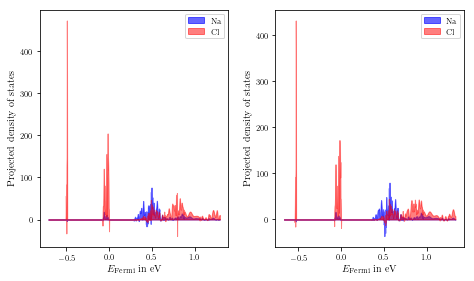

In [6]:
std = pd.read_csv("./ex1/dos/stand/DOSS.DAT", delim_whitespace=True)
opt = pd.read_csv("./ex1/dos/optimal/DOSS.DAT", delim_whitespace=True)

num_vert_plots = 1
num_hor_plots = 2
fig, ax = plt.subplots(num_vert_plots, num_hor_plots, figsize=(fig_width, fig_height))

x_std = std["EFERMI(Eh)"]
x_opt = opt["EFERMI(Eh)"]
names = ["Na", "Cl"]
colors = ["b", "r"]
alphas = [0.6, 0.5]
for i, name in enumerate(names): 
      y = std[name]
      ax[0].fill_between(x_std, y, color=colors[i], alpha=alphas[i], label=names[i])
      ax[0].set_xlabel(r"$E_\mathrm{Fermi}$ in eV")
      ax[0].set_ylabel(r"Projected density of states")
      ax[0].legend(loc="best", fancybox=True)

for i, name in enumerate(names): 
      y = opt[name]
      ax[1].fill_between(x_opt, y, color=colors[i], alpha=alphas[i], label=names[i])
      ax[1].set_xlabel(r"$E_\mathrm{Fermi}$ in eV")
      ax[1].set_ylabel(r"Projected density of states")
      ax[1].legend(loc="best", fancybox=True)

fig.tight_layout()
save_plot_as_pgf(fig, "protocol/Graphen/pdos.pgf")
plt.show()


# 6. Calculating Surfaces of TiO2
### Q7 Lattice parameters and fractional coordinates

In [10]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex2/opt").rglob("*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist


data = []
flist = getFileList()
a_exp = 4.593 # experimental lattice parameter
c_exp = 2.959 # experimental lattice parameter
for i, file in enumerate(flist):
    with open(file) as f:
        for line in f:
            if "    TOTAL CPU TIME =" in line:
                time = float(line.split()[4])
            if "         A              B              C           ALPHA      BETA       GAMMA" in line:
                test = next(f)
                a = float(test.split()[0])
                a_dev = (a / a_exp) - 1 
                c = float(test.split()[2])
                c_dev = (c / c_exp) - 1
            if "      3 T   8 O     3" in line:
                ofrac = float(line.split()[4])

    func = str(file.parent).split("/")[3]
    bas = str(file.parent).split("/")[2]
    method = func.upper()+"/"+bas
    data.append([method, time, a, a_dev, c, c_dev, ofrac])
  
cols = ["Method", "CPU time", "a", "delta A / %", "c", "delta C / %", "xfrac(O)"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex2/tio2-relax.csv")
df.to_csv(save_loc, index=False)

,Method,CPU time,a,delta A / %,c,delta C / %,xfrac(O)
0,PBE0/rev2,20685.456,4.577624,-0.003348,2.950684,-0.002810,0.305030
1,PBESOL/rev2,1140.622,4.589260,-0.000814,2.946441,-0.004244,0.304209
2,PW1PW/rev2,19687.865,4.584675,-0.001813,2.952943,-0.002047,0.304939
3,PWGGA/rev2,3445.462,4.633716,0.008865,2.969167,0.003436,0.304757
4,PBE0/std,11055.102,4.564676,-0.006167,2.980889,0.007397,0.304392
5,PBESOL/std,838.426,4.576977,-0.003489,2.970490,0.003883,0.303625
6,PW1PW/std,13151.061,4.571274,-0.004730,2.981841,0.007719,0.304311
7,PWGGA/std,1425.958,4.616647,0.005148,2.993282,0.011586,0.304078


### Q9 Single point energies

### Q11 Relaxation of symmetry-inequivalent atoms in z-direction

### Q12 Surface energies for different slabs